<h1><center>Laboratory work 7.</center></h1>
<h2><center>PyTorch Paper Replicating Exercises</center></h2>

**Completed:** Last name and First name

**Variant:** #__

<a class="anchor" id="7"></a>

## Outline

1. [Task 1. Replicating ViT with In-built PyTorch Transformer Layers](#7.1)
2. [Task 2. Modularizing ViT into a Python Script](#7.2)
3. [Task 3. Training Pretrained ViT Feature Extractor on 20% Data](#7.3)
4. [Task 4. Training ViT with SWAG Weights](#7.4)
5. [Task 5. Researching ViT Paper Training Techniques](#7.5)

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [07. PyTorch Paper Replicating](https://github.com/radiukpavlo/conducting-experiments/blob/main/01_notebooks/ce_07_pytorch_paper_replicating.ipynb). 

In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


torch version: 1.12.0+cu113
torchvision version: 0.13.0+cu113


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in [07 PyTorch Paper Replicating](https://github.com/radiukpavlo/conducting-experiments/blob/main/01_notebooks/ce_07_pytorch_paper_replicating.ipynb):

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/radiukpavlo/conducting-experiments/blob/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2:

In [7]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [8]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f7e08f76c90>,
 ['pizza', 'steak', 'sushi'])

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

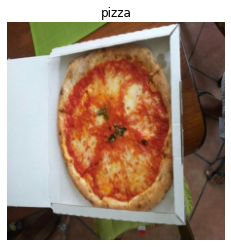

In [10]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

<a class="anchor" id="7.1"></a>

## <span style="color:red; font-size:1.5em;">Task 1. Replicating ViT with In-built PyTorch Transformer Layers</span>

[Go back to the outline](#7)

**Variant 1:**
Replace the custom `TransformerEncoderBlock` class entirely with `torch.nn.TransformerEncoderLayer`. Instantiate a `torch.nn.TransformerEncoder` using six instances of this layer. Ensure the `nhead` parameter is set to 12 and `dim_feedforward` to 3072, matching the ViT-Base configuration. Train this modified ViT model on the `Pizza Steak Sushi` dataset for 10 epochs using the Adam optimizer with a learning rate of 1e-3 and Cross-Entropy loss. Evaluate the model's performance using accuracy, precision, recall, and F1-score on the test set and compare it to the custom implementation's baseline performance. Visualize the training/validation loss curves.

*Technical note:*
This task involves modifying the ViT model architecture defined in the notebook. Use `torch.nn.TransformerEncoderLayer(d_model=768, nhead=12, dim_feedforward=3072, dropout=0.1, activation='gelu', batch_first=True)` and `torch.nn.TransformerEncoder(encoder_layer, num_layers=6)`. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `matplotlib`, `sklearn.metrics`. Evaluation: Accuracy, Precision, Recall, F1-score. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 2:**
Implement the ViT architecture using `torch.nn.TransformerEncoderLayer` but vary the number of attention heads (`nhead`). Create three model instances with `nhead` values of 4, 8, and 16, respectively (adjusting `d_model` to be divisible by `nhead` if necessary, though 768 is divisible by all). Keep `num_layers=6` and `dim_feedforward=3072`. Train each model variant for 5 epochs on the `Pizza Steak Sushi` dataset. Analyze the impact of `nhead` on training speed, final test accuracy, and the number of model parameters. Discuss potential reasons for performance differences based on attention head count.

*Technical note:*
Focus on comparing models built with `torch.nn.TransformerEncoderLayer` and `torch.nn.TransformerEncoder`. Parameters to vary: `nhead` (4, 8, 16). Use `d_model=768`, `num_layers=6`, `dim_feedforward=3072`. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchinfo`, `sklearn.metrics`, `time`. Evaluation: Test Accuracy, Training Time, Parameter Count. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 3:**
Modify the ViT implementation to use `torch.nn.TransformerEncoderLayer` and experiment with different activation functions within the MLP block (`activation` parameter). Compare the default 'relu' activation with 'gelu' (as used in the original ViT paper). Train two separate models for 10 epochs each, keeping all other hyperparameters (`d_model=768`, `nhead=12`, `num_layers=6`, `dim_feedforward=3072`) constant. Evaluate and compare their performance on the `Pizza Steak Sushi` test set using a confusion matrix and overall accuracy. Discuss the potential benefits of using GELU over ReLU in Transformer architectures.

*Technical note:*
This task involves configuring the `activation` parameter in `torch.nn.TransformerEncoderLayer`. Compare `activation='relu'` vs `activation='gelu'`. Libraries: `torch`, `torch.nn`, `torch.optim`, `sklearn.metrics`, `matplotlib`. Evaluation: Accuracy, Confusion Matrix. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`. Train for 10 epochs.

---

**Variant 4:**
Construct the ViT using `torch.nn.TransformerEncoder` and `torch.nn.TransformerEncoderLayer`. Focus on the effect of the MLP hidden dimension (`dim_feedforward`). Train three model variants with `dim_feedforward` values of 1536 (2x d_model), 3072 (4x d_model, ViT-Base default), and 4096 (~5.3x d_model). Keep `d_model=768`, `nhead=12`, `num_layers=6`. Train each for 7 epochs on the `Pizza Steak Sushi` dataset. Analyze the trade-off between model size (parameter count), training time per epoch, and final test set F1-score.

*Technical note:*
Experiment with the `dim_feedforward` parameter in `torch.nn.TransformerEncoderLayer` (1536, 3072, 4096). Use `d_model=768`, `nhead=12`, `num_layers=6`. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchinfo`, `sklearn.metrics`, `time`. Evaluation: F1-score (macro), Training Time, Parameter Count. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 5:**
Build the ViT using the PyTorch in-built transformer layers (`torch.nn.TransformerEncoderLayer`, `torch.nn.TransformerEncoder`). Investigate the impact of varying the number of transformer layers (`num_layers`). Train models with 4, 6 (ViT-Base baseline), and 8 layers. Keep `d_model=768`, `nhead=12`, `dim_feedforward=3072`. Train each model for 10 epochs on the `Pizza Steak Sushi` dataset. Compare their convergence speed (epochs to reach >70% validation accuracy), final test accuracy, and total parameter count. Discuss the concept of model depth in Transformers.

*Technical note:*
Vary the `num_layers` parameter in `torch.nn.TransformerEncoder` (4, 6, 8). Use `torch.nn.TransformerEncoderLayer` with `d_model=768`, `nhead=12`, `dim_feedforward=3072`. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchinfo`, `sklearn.metrics`, `matplotlib`. Evaluation: Test Accuracy, Parameter Count, Convergence Speed analysis. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 6:**
Implement the ViT using `torch.nn.TransformerEncoderLayer` and `torch.nn.TransformerEncoder`. This time, investigate the effect of dropout probability within the transformer layers. Train three models with dropout rates of 0.0, 0.1 (ViT default), and 0.2 applied within the `TransformerEncoderLayer` (attention and MLP dropout). Keep all other ViT-Base parameters constant (`d_model=768`, `nhead=12`, `num_layers=6`, `dim_feedforward=3072`). Train for 15 epochs. Compare training vs. validation loss curves to observe overfitting tendencies. Report test accuracy and discuss dropout's role as a regularizer in this context.

*Technical note:*
Focus on the `dropout` parameter within `torch.nn.TransformerEncoderLayer` (0.0, 0.1, 0.2). Use `d_model=768`, `nhead=12`, `num_layers=6`, `dim_feedforward=3072`. Libraries: `torch`, `torch.nn`, `torch.optim`, `sklearn.metrics`, `matplotlib`. Evaluation: Test Accuracy, Training/Validation Loss Curves Analysis. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 7:**
Create a ViT model using `torch.nn.TransformerEncoder` and `torch.nn.TransformerEncoderLayer`. Instead of the standard patch embedding using a Conv2d layer, implement patch embedding using `torch.nn.Unfold` followed by a `torch.nn.Linear` layer. Ensure the output dimension matches the required embedding dimension (768). Compare the parameter count and training speed (for 5 epochs) of this implementation against the Conv2d patch embedding version (using the same ViT-Base transformer block parameters: `num_layers=6`, `nhead=12`, `dim_feedforward=3072`). Report the final test accuracy for both.

*Technical note:*
Replace `nn.Conv2d` in the patch embedding module with `nn.Unfold` and `nn.Linear`. Compare parameter count, training speed, and accuracy. Use `d_model=768`, `patch_size=16`. Transformer uses `num_layers=6`, `nhead=12`, `dim_feedforward=3072`. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchinfo`, `sklearn.metrics`, `time`. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 8:**
Replicate the ViT using PyTorch's built-in layers (`torch.nn.TransformerEncoderLayer`, `torch.nn.TransformerEncoder`). Add Layer Normalization (`torch.nn.LayerNorm`) *after* the final `torch.nn.TransformerEncoder` block, just before the MLP head, as described in the paper (Figure 1, "Norm"). Train one model with this additional LayerNorm and one without it (using the ViT-Base configuration otherwise: `num_layers=6`, `d_model=768`, `nhead=12`, `dim_feedforward=3072`). Train both for 10 epochs. Compare their training stability (loss curve smoothness) and final test accuracy on the `Pizza Steak Sushi` dataset.

*Technical note:*
Modify the ViT architecture by adding an extra `nn.LayerNorm(d_model)` before the final classification `nn.Linear` layer. Compare performance with and without this layer. Use `d_model=768`, `nhead=12`, `num_layers=6`, `dim_feedforward=3072`. Libraries: `torch`, `torch.nn`, `torch.optim`, `sklearn.metrics`, `matplotlib`. Evaluation: Test Accuracy, Loss Curve Analysis. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 9:**
Implement the ViT using `torch.nn.TransformerEncoderLayer` and `torch.nn.TransformerEncoder`. Focus on the class token and position embedding. Modify the implementation to use *learned* position embeddings instead of fixed sinusoidal ones (if the base notebook used fixed) or vice-versa. Ensure the embeddings are added correctly to the patch embeddings. Train both versions (learned vs. fixed, assuming one was the baseline) for 8 epochs using ViT-Base parameters (`num_layers=6`, `d_model=768`, `nhead=12`, `dim_feedforward=3072`). Compare their final test set precision and recall scores.

*Technical note:*
Modify the position embedding implementation. Compare `nn.Parameter(torch.randn(1, num_patches + 1, d_model))` (learned) vs. a fixed sinusoidal implementation. Use `d_model=768`, `patch_size=16`. Transformer uses `num_layers=6`, `nhead=12`, `dim_feedforward=3072`. Libraries: `torch`, `torch.nn`, `torch.optim`, `sklearn.metrics`. Evaluation: Precision, Recall (macro). Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 10:**
Build the ViT using PyTorch's built-in layers. Instead of using the standard Adam optimizer, experiment with AdamW (`torch.optim.AdamW`), which includes weight decay regularization decoupled from the learning rate adaptation. Train two models: one with Adam (lr=1e-3) and one with AdamW (lr=1e-3, weight_decay=0.01). Use the standard ViT-Base configuration (`num_layers=6`, `d_model=768`, `nhead=12`, `dim_feedforward=3072`). Train for 12 epochs. Compare their performance using validation accuracy curves and final test F1-score on the `Pizza Steak Sushi` dataset.

*Technical note:*
Compare `torch.optim.Adam` vs `torch.optim.AdamW`. Parameters: `lr=1e-3`, `weight_decay=0.01` for AdamW. Use ViT-Base config. Libraries: `torch`, `torch.nn`, `torch.optim`, `sklearn.metrics`, `matplotlib`. Evaluation: F1-score (macro), Validation Accuracy Curve comparison. Loss: `nn.CrossEntropyLoss()`.

---

**Variant 11:**
Replicate the ViT architecture using `torch.nn.TransformerEncoderLayer` and `torch.nn.TransformerEncoder`. Modify the Multi-Head Self-Attention mechanism within the `TransformerEncoderLayer` by setting `batch_first=False` (the default). Adjust the input tensor shapes accordingly throughout the model (especially patch embedding and position embedding outputs, expecting shape `[seq_len, batch_size, embedding_dim]`). Train this version for 5 epochs and compare its training speed per epoch and memory usage (if possible using tools like `torch.cuda.memory_summary`) against the `batch_first=True` version. Report test accuracy for both.

*Technical note:*
Change `batch_first=False` in `nn.TransformerEncoderLayer` and adjust tensor permutations (`permute()`) where needed. Compare training speed, memory usage, and accuracy. Use ViT-Base parameters (`d_model=768`, `nhead=12`, `num_layers=6`, `dim_feedforward=3072`). Libraries: `torch`, `torch.nn`, `torch.optim`, `sklearn.metrics`, `time`. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 12:**
Implement ViT using `torch.nn.TransformerEncoderLayer` and `torch.nn.TransformerEncoder`. Explore the `norm_first` parameter within `torch.nn.TransformerEncoderLayer`. Train two models: one with `norm_first=False` (Post-LN, the default described in "Attention Is All You Need") and one with `norm_first=True` (Pre-LN, often found to improve stability in deeper Transformers). Use ViT-Base parameters (`d_model=768`, `nhead=12`, `num_layers=6`, `dim_feedforward=3072`). Train for 15 epochs. Compare their training loss curves for stability and report the final test accuracy and F1-score.

*Technical note:*
Compare `norm_first=False` vs `norm_first=True` in `nn.TransformerEncoderLayer`. Use ViT-Base config. Libraries: `torch`, `torch.nn`, `torch.optim`, `sklearn.metrics`, `matplotlib`. Evaluation: Test Accuracy, F1-score (macro), Training Loss Curve stability analysis. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 13:**
Build the ViT using PyTorch's built-in layers. Focus on the patch size. Modify the patch embedding layer (`nn.Conv2d`) and subsequent calculations (number of patches, position embedding size) to work with a patch size of 32x32 instead of 16x16. Keep the embedding dimension `d_model=768`. Train this model using the ViT-Base transformer parameters (`num_layers=6`, `nhead=12`, `dim_feedforward=3072`) for 10 epochs. Compare its parameter count, FLOPS (using `torchinfo`), and test accuracy against the original 16x16 patch size version. Discuss the trade-offs.

*Technical note:*
Change `patch_size` to 32. Adjust `nn.Conv2d(in_channels=3, out_channels=768, kernel_size=32, stride=32)` and recalculate `num_patches`. Compare params, FLOPS, accuracy. Use ViT-Base transformer params. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchinfo`, `sklearn.metrics`. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 14:**
Replicate ViT with `torch.nn.TransformerEncoderLayer` and `torch.nn.TransformerEncoder`. Remove the class (`[CLS]`) token entirely. Instead, perform global average pooling (GAP) on the output patch embeddings *after* the final Transformer Encoder layer. Pass the GAP output through the MLP head for classification. Train this modified architecture for 10 epochs using ViT-Base parameters (`num_layers=6`, `d_model=768`, `nhead=12`, `dim_feedforward=3072`). Compare its test accuracy and number of parameters to the original CLS token version.

*Technical note:*
Remove the `cls_token` parameter and logic. Add `nn.AdaptiveAvgPool1d(1)` or equivalent pooling after the `nn.TransformerEncoder` output (ensure correct dimensions), then flatten and pass to the MLP head. Compare params, accuracy. Use ViT-Base transformer params. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchinfo`, `sklearn.metrics`. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 15:**
Implement ViT using PyTorch's built-in layers. Experiment with the learning rate scheduler `torch.optim.lr_scheduler.StepLR`. Train the ViT-Base configuration model (`num_layers=6`, `d_model=768`, `nhead=12`, `dim_feedforward=3072`) for 15 epochs using Adam (lr=1e-3). Apply `StepLR` with `step_size=5` and `gamma=0.1` (reducing LR by 10x every 5 epochs). Plot the learning rate over epochs. Compare the validation loss curve and final test accuracy against training with a constant learning rate (the baseline).

*Technical note:*
Use `torch.optim.lr_scheduler.StepLR` with Adam. Parameters: `step_size=5`, `gamma=0.1`. Plot LR schedule. Compare validation loss and test accuracy. Use ViT-Base config. Libraries: `torch`, `torch.nn`, `torch.optim`, `torch.optim.lr_scheduler`, `sklearn.metrics`, `matplotlib`. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 16:**
Build the ViT using `torch.nn.TransformerEncoderLayer` and `torch.nn.TransformerEncoder`. Initialize the weights differently. Instead of the default PyTorch initializations, apply Xavier uniform initialization (`torch.nn.init.xavier_uniform_`) to the linear layers within the MSA and MLP blocks (specifically, the projection layers `qkv`, `proj` in attention, and the layers in the MLP). Train this model for 10 epochs using ViT-Base parameters and compare its convergence speed (validation accuracy per epoch) and final test accuracy against the default initialization.

*Technical note:*
Apply `torch.nn.init.xavier_uniform_` to relevant `nn.Linear` layers within a custom `TransformerEncoderLayer` or by iterating through the layers of the standard one after instantiation. Compare convergence and test accuracy. Use ViT-Base config. Libraries: `torch`, `torch.nn`, `torch.optim`, `sklearn.metrics`, `matplotlib`. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 17:**
Create a "ViT-Small" configuration using `torch.nn.TransformerEncoderLayer` and `torch.nn.TransformerEncoder`. Use reduced parameters: `num_layers=4`, `d_model=512`, `nhead=8`, `dim_feedforward=2048`. Ensure the patch embedding layer output dimension matches `d_model`. Train this smaller model for 10 epochs on the `Pizza Steak Sushi` dataset. Compare its parameter count, training time per epoch, and final test accuracy against the ViT-Base configuration built with the same PyTorch layers.

*Technical note:*
Implement a ViT with reduced dimensions: `num_layers=4`, `d_model=512`, `nhead=8`, `dim_feedforward=2048`. Adjust patch embedding output `out_channels` to 512. Compare params, speed, accuracy vs. ViT-Base (`num_layers=6`, `d_model=768`, `nhead=12`, `dim_feedforward=3072`). Libraries: `torch`, `torch.nn`, `torch.optim`, `torchinfo`, `sklearn.metrics`, `time`. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 18:**
Replicate the ViT using PyTorch's built-in layers. Add Stochastic Depth (DropPath) regularization after the MSA and MLP blocks within the `TransformerEncoderLayer`. You might need to slightly modify the `TransformerEncoderLayer` or create a custom block incorporating `torchvision.ops.stochastic_depth`. Use a stochastic depth probability starting from 0.0 and linearly increasing to 0.1 across the layers. Train this model for 15 epochs using ViT-Base parameters and compare its test accuracy and F1-score against the baseline without DropPath.

*Technical note:*
Incorporate `torchvision.ops.stochastic_depth` (DropPath). Use a linearly increasing probability (e.g., `p = layer_idx / (num_layers - 1) * max_p`, where `max_p=0.1`). Compare test accuracy and F1 vs baseline. Use ViT-Base config. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision.ops`, `sklearn.metrics`. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 19:**
Build the ViT using `torch.nn.TransformerEncoderLayer` and `torch.nn.TransformerEncoder`. Modify the final MLP head. Instead of a single linear layer for classification, use a two-layer MLP head: `Linear(d_model, mlp_hidden_dim) -> GELU -> Dropout(0.1) -> Linear(mlp_hidden_dim, num_classes)`. Choose `mlp_hidden_dim = 1024`. Train this modified ViT-Base model for 10 epochs. Compare its performance (test accuracy, precision, recall) against the single-layer MLP head version.

*Technical note:*
Replace the final `nn.Linear(d_model, num_classes)` with a sequence: `nn.Linear(768, 1024)`, `nn.GELU()`, `nn.Dropout(0.1)`, `nn.Linear(1024, num_classes)`. Compare performance metrics. Use ViT-Base transformer config. Libraries: `torch`, `torch.nn`, `torch.optim`, `sklearn.metrics`. Optimizer: Adam (lr=1e-3). Loss: `nn.CrossEntropyLoss()`.

---

**Variant 20:**
Implement ViT using PyTorch's built-in layers. Perform a basic sensitivity analysis on the learning rate. Train the ViT-Base configuration for 5 epochs each using Adam with learning rates of 1e-2, 1e-3 (baseline), 1e-4, and 1e-5. Plot the training loss curves for all runs on the same graph. Report the final validation accuracy for each learning rate and discuss which rate appears most promising for longer training based on the initial convergence behavior.

*Technical note:*
Train multiple short runs varying only the learning rate (`lr` in `torch.optim.Adam`: 1e-2, 1e-3, 1e-4, 1e-5). Use ViT-Base config. Plot training losses. Report validation accuracies. Libraries: `torch`, `torch.nn`, `torch.optim`, `sklearn.metrics`, `matplotlib`. Evaluation: Training loss comparison, Validation Accuracy. Loss: `nn.CrossEntropyLoss()`.

---

<a class="anchor" id="7.2"></a>

## <span style="color:red; font-size:1.5em;">Task 2. Modularizing ViT into a Python Script</span>

[Go back to the outline](#7)

**Variant 1:**
Create a Python script named `my_vit_model.py`. Define the complete custom ViT architecture (including `PatchEmbedding`, `MultiHeadSelfAttentionBlock`, `MLPBlock`, `TransformerEncoderBlock`, and the final `ViT` class) within this script. Ensure it takes standard ViT-Base parameters as arguments (`img_size=224`, `patch_size=16`, `num_transformer_layers=6`, etc.). In your notebook, import the `ViT` class using `from my_vit_model import ViT`. Instantiate the model, print its summary using `torchinfo.summary`, and verify it matches the expected architecture and parameter count.

*Technical note:*
Move all ViT class definitions (custom implementation from the notebook) into `my_vit_model.py`. Import `ViT` in the notebook. Instantiate with ViT-Base parameters. Use `torchinfo.summary(vit_model, input_size=(1, 3, 224, 224))` to verify. Libraries: `torch`, `torch.nn`, `torchinfo`, (inside script: `torch`, `torch.nn`). Evaluation: Correct import, architecture summary verification.

---

**Variant 2:**
Refactor the custom ViT architecture into a script `vision_transformer.py`. Within the script, define separate functions or classes for each component (Patch Embedding, MSA, MLP, Transformer Encoder Block). The main `ViT` class should then assemble these components. Add basic docstrings to each class and function explaining its purpose, inputs, and outputs. Import the `ViT` class in the notebook, instantiate it, and perform a forward pass with a dummy tensor `torch.randn(1, 3, 224, 224)` to ensure it runs without errors and outputs the correct shape `(1, num_classes)`.

*Technical note:*
Organize code in `vision_transformer.py` into distinct component classes/functions with docstrings. Import `ViT`. Test forward pass: `dummy_input = torch.randn(1, 3, 224, 224); output = model(dummy_input)`. Check `output.shape`. Libraries: `torch`, `torch.nn` (in script and notebook). Evaluation: Successful import, error-free forward pass, correct output shape.

---

**Variant 3:**
Create `vit_module.py` containing the custom ViT implementation. Modify the `ViT` class's `__init__` method to accept hyperparameters like `embedding_dim`, `num_heads`, `num_layers`, `mlp_size`, `patch_size`, and `num_classes` as arguments. Add type hints to these arguments. In the notebook, import `ViT` and instantiate two different configurations: a "ViT-Tiny" (`embedding_dim=256`, `num_heads=4`, `num_layers=4`, `mlp_size=1024`) and the standard "ViT-Base". Print the `torchinfo.summary` for both to verify the parameter differences.

*Technical note:*
Modify `ViT.__init__` in `vit_module.py` to accept hyperparameters with type hints (e.g., `embedding_dim: int = 768`). Instantiate ViT-Tiny and ViT-Base configs. Compare `torchinfo.summary` outputs. Libraries: `torch`, `torch.nn`, `torchinfo` (in notebook). Evaluation: Correct instantiation of different configs, parameter count verification via summary.

---

**Variant 4:**
Develop `vit_script.py` containing the custom ViT model. Add a simple command-line interface using `argparse`. Allow the user to specify the desired image size (`--img_size`) and patch size (`--patch_size`) when running the script. The script should then instantiate the `ViT` model with these parameters (using defaults like ViT-Base for others) and print the `torchinfo.summary`. Execute the script from your notebook using `!python vit_script.py --img_size 256 --patch_size 32` and verify the output summary reflects the specified parameters.

*Technical note:*
Add `argparse` to `vit_script.py`. Define arguments `--img_size` and `--patch_size`. Instantiate `ViT` using parsed args. Print summary. Run script from notebook cell using `!python`. Libraries: `torch`, `torch.nn`, `torchinfo`, `argparse` (in script). Evaluation: Script execution via `!python`, summary output verification based on CLI args.

---

**Variant 5:**
Place the custom ViT architecture code into `vit_architecture.py`. Create a separate helper function within the script, e.g., `create_vit_model(num_classes: int, config: str = 'ViT-Base', **kwargs) -> nn.Module`, that handles model instantiation based on a configuration string ('ViT-Base', 'ViT-Small', etc.) or allows overriding parameters via `kwargs`. Implement logic for at least 'ViT-Base' and 'ViT-Small' (similar to Variant 3). In the notebook, import this function `from vit_architecture import create_vit_model` and use it to create both configurations, printing their summaries.

*Technical note:*
Create a factory function `create_vit_model` in `vit_architecture.py`. Handle config strings ('ViT-Base', 'ViT-Small') and `kwargs`. Import and use the function in the notebook. Verify summaries. Libraries: `torch`, `torch.nn`, `torchinfo` (in notebook). Evaluation: Successful import and use of the factory function, correct summary outputs for different configs.

---

**Variant 6:**
Modularize the custom ViT code into `vit_model.py`. Add basic error handling, such as asserting that `img_size` is divisible by `patch_size` in the `ViT` class `__init__`. Also, check if `embedding_dim` is divisible by `num_heads` in the `MultiHeadSelfAttentionBlock`. In the notebook, import the `ViT` class. Intentionally try to instantiate it with incompatible parameters (e.g., `img_size=224`, `patch_size=15`) and verify that the appropriate assertion error is raised. Then, instantiate correctly and show the summary.

*Technical note:*
Add `assert img_size % patch_size == 0` and `assert embedding_dim % num_heads == 0` checks in the respective `__init__` methods within `vit_model.py`. Test instantiation with invalid and valid parameters in the notebook. Libraries: `torch`, `torch.nn`, `torchinfo` (in notebook). Evaluation: Correct error raising for invalid parameters, successful instantiation with valid parameters.

---

**Variant 7:**
Create `vit_components.py`. Define only the building block classes: `PatchEmbedding`, `MultiHeadSelfAttentionBlock`, `MLPBlock`, `TransformerEncoderBlock`. In your notebook, import these individual components. Reconstruct the full `ViT` class *within the notebook* by importing and assembling these components. Instantiate the notebook-defined `ViT` class and verify its architecture using `torchinfo.summary`. This tests the modularity and reusability of the components defined in the script.

*Technical note:*
Define only component classes in `vit_components.py`. Import them into the notebook (`from vit_components import PatchEmbedding, ...`). Define the `ViT` class in a notebook cell using these imported components. Verify architecture with `torchinfo.summary`. Libraries: `torch`, `torch.nn`, `torchinfo` (in notebook). Evaluation: Successful import of components, correct assembly of ViT in the notebook, architecture verification.

---

**Variant 8:**
Move the entire custom ViT implementation into `vit.py`. Create a companion script `train_vit.py` that imports `ViT` from `vit.py`. This training script should also include the necessary data loading setup (using `create_dataloaders` potentially imported from another helper script or defined within) and the training loop logic (similar to `engine.py`). Add `argparse` to `train_vit.py` to set basic hyperparameters like learning rate and number of epochs. Run `!python train_vit.py --epochs 5 --lr 0.001` from the notebook to train the model using the script. Report the final accuracy printed by the script.

*Technical note:*
Create `vit.py` (model) and `train_vit.py` (imports model, data setup, training loop, argparse). Run `train_vit.py` via `!python` from the notebook. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `argparse`, `sklearn.metrics` (in `train_vit.py`). Evaluation: Successful script execution, script outputs training progress/final accuracy.

---

**Variant 9:**
Put the custom ViT code in `vision_transformer_pkg/model.py`. Create an empty `vision_transformer_pkg/__init__.py` file to make it a package. In your notebook, ensure the package directory is accessible (e.g., using `sys.path.append`) and import the model using `from vision_transformer_pkg.model import ViT`. Instantiate the model and perform a forward pass with a dummy tensor to confirm the package structure works correctly. Print the model summary.

*Technical note:*
Create a directory `vision_transformer_pkg` with `model.py` (containing ViT code) and an empty `__init__.py`. Import using package notation in the notebook. Verify instantiation, forward pass, and summary. Libraries: `torch`, `torch.nn`, `torchinfo`, `sys` (in notebook). Evaluation: Successful import from package structure, forward pass check, summary verification.

---

**Variant 10:**
Create `vit_configurable.py` containing the custom ViT. Use a dictionary to define configurations (e.g., `VIT_CONFIGS = {'ViT-Base': {'num_layers': 6, 'd_model': 768, ...}, 'ViT-Small': {...}}`). Modify the `ViT` class `__init__` to accept a config dictionary or a config name string. If a string is passed, look it up in `VIT_CONFIGS`. Import `ViT` in the notebook. Instantiate using both methods: `ViT(config_name='ViT-Base', num_classes=3)` and `ViT(config={'num_layers': 4, ...}, num_classes=3)`. Verify summaries match expectations.

*Technical note:*
Define a config dictionary `VIT_CONFIGS` in `vit_configurable.py`. Modify `ViT.__init__` to accept `config_name` or `config` dict. Test both instantiation methods in the notebook. Verify summaries. Libraries: `torch`, `torch.nn`, `torchinfo` (in notebook). Evaluation: Successful instantiation via config name and dict, summary verification.

---

**Variant 11:**
Modularize the ViT code into `vit_model.py`. Add a `forward_features` method to the `ViT` class that performs the forward pass up to *before* the final MLP head (returning the processed class token or pooled patch embeddings). In the notebook, import `ViT`, instantiate it, pass a dummy image tensor through `forward_features`, and print the shape of the output feature tensor. This is useful for using the ViT as a feature extractor.

*Technical note:*
Add a method `forward_features(self, x)` to `ViT` in `vit_model.py` returning the tensor input to the MLP head. Test this method in the notebook and check the output shape (e.g., `(batch_size, embedding_dim)`). Libraries: `torch`, `torch.nn` (in script and notebook). Evaluation: Correct implementation of `forward_features`, verification of output shape.

---

**Variant 12:**
Create `vit_script_with_logging.py` based on Variant 4 (ViT script with argparse). Add basic logging using Python's `logging` module. Log information messages about the configuration being used (image size, patch size) and the total number of parameters after instantiation. Run the script from the notebook using `!python vit_script_with_logging.py --img_size 224 --patch_size 16` and check if the log messages appear in the notebook output.

*Technical note:*
Add `import logging` and configure basic logging (e.g., `logging.basicConfig(level=logging.INFO)`) in `vit_script_with_logging.py`. Add `logging.info(...)` calls. Run via `!python`. Libraries: `torch`, `torch.nn`, `torchinfo`, `argparse`, `logging` (in script). Evaluation: Script execution, verification of log messages in output.

---

**Variant 13:**
Place the custom ViT code into `vit_utils.py`. Create a separate function `get_vit_transforms(img_size: int = 224)` within the same script that returns a `torchvision.transforms.Compose` object suitable for ViT preprocessing (Resize, ToTensor, Normalize with ImageNet means/stds). In your notebook, import both `ViT` and `get_vit_transforms`. Use the function to get transforms, create DataLoaders for `Pizza Steak Sushi`, instantiate the model, and train for 1 epoch to ensure compatibility.

*Technical note:*
Define `get_vit_transforms` function returning `transforms.Compose([...])` in `vit_utils.py`. Import and use both function and `ViT` class in the notebook. Perform data loading and a single epoch training run. Libraries: `torch`, `torch.nn`, `torchvision.transforms`, `torch.optim` (in notebook and script). Evaluation: Successful import, data loading with imported transforms, completion of 1 training epoch without errors.

---

**Variant 14:**
Modularize the custom ViT into `my_vit.py`. Add comments within the script explaining the dimensions of the tensors after key operations (e.g., after patch embedding, after adding position embedding, input/output of MSA, input/output of MLP). Import the `ViT` class in the notebook, instantiate it, and review the commented code in `my_vit.py` to understand the tensor flow, verifying against the shapes printed by `torchinfo.summary`.

*Technical note:*
Add detailed comments explaining tensor shapes (e.g., `# Output shape: (batch_size, num_patches + 1, embedding_dim)`) within the `ViT` class methods in `my_vit.py`. Review the script's comments alongside the `torchinfo.summary` output in the notebook. Libraries: `torch`, `torch.nn`, `torchinfo` (in notebook). Evaluation: Review and verification of commented shapes against summary.

---

**Variant 15:**
Create `vit_package/model.py` and `vit_package/__init__.py` (similar to Variant 9). Add another file `vit_package/config.py` defining the configuration dictionaries (like Variant 10). Modify `model.py` to import configurations from `vit_package.config`. In the notebook, import `ViT` using `from vit_package.model import ViT`, instantiate using a config name (e.g., 'ViT-Base'), and print the summary. This tests intra-package imports.

*Technical note:*
Create `vit_package` with `model.py`, `__init__.py`, `config.py`. `model.py` should `from .config import VIT_CONFIGS`. Import `ViT` in notebook using package path. Instantiate and verify summary. Libraries: `torch`, `torch.nn`, `torchinfo`, `sys` (in notebook). Evaluation: Successful import using intra-package structure, model instantiation, summary verification.

---

**Variant 16:**
Put the custom ViT code into `vit_model_core.py`. Create a wrapper script `vit_interface.py` that imports `ViT` from `vit_model_core.py`. This interface script could add functionality, e.g., a method `.predict(image_path)` that takes a file path, loads/transforms the image, and returns the predicted class name. Implement this `.predict` method (you'll need `PIL` and `torchvision.transforms`). In the notebook, import the enhanced `ViT` from `vit_interface.py`, instantiate it (loading trained weights if available, otherwise using random), and test the `.predict` method on a sample image from the dataset.

*Technical note:*
Create `vit_model_core.py` (base ViT) and `vit_interface.py` (imports base ViT, adds `.predict` method using `PIL`, `transforms`). Test `.predict` in notebook. Libraries: `torch`, `torch.nn`, `torchvision.transforms`, `PIL` (in `vit_interface.py`). Evaluation: Implementation of `.predict`, successful prediction on a sample image.

---

**Variant 17:**
Modularize the ViT into `model_vit.py`. Ensure the script includes necessary imports (`torch`, `torch.nn`). In the notebook, use the `%run` magic command (`%run model_vit.py`) to execute the script. Verify that the ViT class definition is now available in the notebook's namespace without explicit import statements. Instantiate the model directly (e.g., `model = ViT(...)`) and print its summary. Discuss the difference between `%run` and standard imports.

*Technical note:*
Use `%run model_vit.py` in a notebook cell. Instantiate `ViT` directly. Print summary. Libraries: `torch`, `torch.nn` (in script), `torchinfo` (in notebook). Evaluation: Successful execution via `%run`, class availability in namespace, model instantiation, summary verification.

---

**Variant 18:**
Create `vit_modules/patch_embedding.py`, `vit_modules/attention.py`, `vit_modules/mlp.py`, `vit_modules/encoder.py`, and `vit_modules/vit.py`, each containing the respective class definition. Create `vit_modules/__init__.py` and import the main `ViT` class into it (`from .vit import ViT`). In the notebook, import the model using `from vit_modules import ViT`. This structure mimics larger library layouts. Instantiate and print the summary.

*Technical note:*
Create a directory `vit_modules` with separate files for each component and `__init__.py` (importing `ViT`). Import `ViT` from the package top-level in the notebook. Instantiate and verify summary. Libraries: `torch`, `torch.nn`, `torchinfo`, `sys` (in notebook). Evaluation: Successful modularization into multiple files, correct package import, model instantiation, summary verification.

---

**Variant 19:**
Place the custom ViT into `configurable_vit.py`. Add default values for all hyperparameters in the `ViT` class `__init__` method corresponding to the ViT-Base configuration (`img_size=224`, `patch_size=16`, `embedding_dim=768`, etc.). Ensure the model can be instantiated with *only* the `num_classes` argument, e.g., `model = ViT(num_classes=3)`. Import and instantiate the model this way in the notebook, then print the `torchinfo.summary` to verify it defaults to ViT-Base.

*Technical note:*
Add default arguments to `ViT.__init__` in `configurable_vit.py` matching ViT-Base. Instantiate with only `num_classes` in the notebook. Verify summary matches ViT-Base. Libraries: `torch`, `torch.nn`, `torchinfo` (in notebook). Evaluation: Correct implementation of defaults, successful instantiation with minimal args, summary verification.

---

**Variant 20:**
Create `vit_for_notebook.py`. Define the ViT class inside. Add a static method `ViT.create_base_model(num_classes)` that returns a ViT instance pre-configured with ViT-Base parameters. In the notebook, import `ViT` and call the static method: `model = ViT.create_base_model(num_classes=3)`. Print the model summary to verify the configuration. This provides a convenient way to get standard configurations from the script.

*Technical note:*
Add a `@staticmethod create_base_model(num_classes)` to the `ViT` class in `vit_for_notebook.py`. This method should instantiate `ViT` with hardcoded ViT-Base parameters. Call the static method in the notebook. Verify summary. Libraries: `torch`, `torch.nn`, `torchinfo` (in notebook). Evaluation: Correct static method implementation, successful instantiation via static method, summary verification.

---

<a class="anchor" id="7.3"></a>

## <span style="color:red; font-size:1.5em;">Task 3. Training Pretrained ViT Feature Extractor on 20% Data</span>

[Go back to the outline](#7)

**Variant 1:**
Load the pretrained `vit_b_16` model from `torchvision.models` using `weights=ViT_B_16_Weights.DEFAULT`. Freeze all parameters except the final classifier head. Create a 20% subset of the `Pizza Steak Sushi` training data (ensure reproducibility using a fixed random seed for subset selection). Train *only* the classifier head on this 20% subset for 10 epochs using Adam (lr=1e-3). Evaluate performance (accuracy, F1-score) on the full test set. Compare this accuracy to the baseline EffNetB2 result mentioned in the lecture/notebook (if available).

*Technical note:*
Use `torchvision.models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT)`. Freeze parameters (`param.requires_grad = False`) except for `model.heads.head`. Create 20% training subset using `torch.utils.data.Subset` or sklearn's `train_test_split` on indices. Train classifier head. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision.models`, `torchvision.transforms`, `sklearn.model_selection`, `sklearn.metrics`. Evaluation: Accuracy, F1-score (macro) on full test set. Optimizer: Adam (lr=1e-3).

---

**Variant 2:**
Repeat Variant 1 (pretrained ViT-B/16, default weights, freeze all but head, 20% training data). However, instead of Adam, use the SGD optimizer with momentum (`momentum=0.9`) and a learning rate of 1e-2 for 15 epochs. Apply a learning rate scheduler, `StepLR` with `step_size=5`, `gamma=0.1`. Evaluate accuracy and plot the training/validation loss curves. Compare the convergence behavior and final accuracy to using Adam (from Variant 1 or the lecture).

*Technical note:*
Use `torch.optim.SGD(model.heads.head.parameters(), lr=1e-2, momentum=0.9)`. Add `torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)`. Train on 20% subset, evaluating on full test set. Libraries: `torch`, `torch.nn`, `torch.optim`, `torch.optim.lr_scheduler`, `torchvision`, `sklearn`, `matplotlib`. Evaluation: Accuracy, Loss Curves.

---

**Variant 3:**
Load the pretrained `vit_b_16` (default weights). Instead of freezing *all* base layers, unfreeze the final Transformer Encoder block (`model.encoder.layers[-1]`) in addition to the classifier head. Train this partially unfrozen model on the 20% `Pizza Steak Sushi` training subset for 10 epochs using Adam (lr=1e-4 to avoid disrupting pretrained weights too much). Evaluate accuracy and compare it to the result obtained when only the head was unfrozen (Variant 1). Discuss the potential benefits/drawbacks of unfreezing more layers.

*Technical note:*
Freeze all params, then unfreeze `model.heads.head` and `model.encoder.layers[-1]`. Use a lower LR, e.g., `torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)`. Train on 20% subset. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Accuracy comparison.

---

**Variant 4:**
Use the pretrained `vit_b_16` (default weights), freezing all but the head. Create the 20% training subset. Apply more aggressive data augmentation during training using `torchvision.transforms`. Add `RandomRotation(degrees=15)`, `RandomHorizontalFlip(p=0.5)`, and `RandomPerspective(distortion_scale=0.2, p=0.5)` to the training transforms (keep test transforms simple: Resize, ToTensor, Normalize). Train for 15 epochs using Adam (lr=1e-3). Evaluate the F1-score and compare it to training with basic augmentation (just Resize, ToTensor, Normalize) on the same 20% subset (Variant 1).

*Technical note:*
Add `transforms.RandomRotation`, `transforms.RandomHorizontalFlip`, `transforms.RandomPerspective` to training `transforms.Compose`. Freeze all but head. Train on 20% subset. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: F1-score comparison (with vs. without extra augmentation). Optimizer: Adam (lr=1e-3).

---

**Variant 5:**
Load pretrained `vit_b_16` (default weights), freeze all but head. Focus on the subset creation. Instead of a random 20% subset, create a 20% subset that is intentionally *imbalanced*: take 80% of the 'pizza' training images, 10% of 'steak', and 10% of 'sushi' that constitute 20% of the total training set. Train on this imbalanced subset for 10 epochs (Adam, lr=1e-3). Evaluate using a confusion matrix and per-class precision/recall on the full (balanced) test set. Analyze the performance bias towards the majority class.

*Technical note:*
Manually create an imbalanced 20% training subset (e.g., by filtering `ImageFolder.samples`). Freeze all but head. Train. Evaluate using `sklearn.metrics.classification_report(..., output_dict=True)` and `ConfusionMatrixDisplay`. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Confusion Matrix, Per-class Precision/Recall analysis.

---

**Variant 6:**
Use pretrained `vit_b_16` (default weights), freeze all but head. Train on a random 20% subset for 10 epochs (Adam, lr=1e-3). After training, use techniques like Grad-CAM (e.g., using the `captum` library or a simpler implementation) to visualize which parts of *test* images the model focuses on for each class (pizza, steak, sushi). Analyze a few examples (e.g., 2 per class) and discuss if the attention maps align with the actual food items in the images.

*Technical note:*
Train model as in Variant 1. Then apply Grad-CAM or similar attention visualization technique on test images. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`, `matplotlib`, potentially `captum`, `cv2`, `numpy`. Evaluation: Qualitative analysis of attention maps.

---

**Variant 7:**
Load pretrained `vit_b_16` (default weights). Freeze all layers. Replace the final classifier head (`model.heads.head`) with a custom two-layer MLP: `Linear(768, 512) -> ReLU -> Dropout(0.3) -> Linear(512, num_classes)`. Train *only* this custom head on the 20% training subset for 10 epochs (Adam, lr=1e-3). Compare its test accuracy to the single-layer head baseline (Variant 1).

*Technical note:*
Replace `model.heads.head` with a custom `nn.Sequential(nn.Linear(768, 512), nn.ReLU(), nn.Dropout(0.3), nn.Linear(512, num_classes))`. Freeze base model. Train the head on 20% subset. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Accuracy comparison.

---

**Variant 8:**
Use pretrained `vit_b_16` (default weights), freeze all but head. Train on the 20% training subset. Experiment with different batch sizes for training: 16, 32 (baseline), and 64. Train each configuration for 10 epochs (Adam, lr=1e-3). Compare the training time per epoch, the smoothness of the validation loss curves, and the final test accuracy for each batch size. Discuss the impact of batch size on training dynamics and potential GPU memory limitations.

*Technical note:*
Vary `batch_size` in `DataLoader` (16, 32, 64). Freeze all but head. Train on 20% subset. Compare speed, loss curves, accuracy. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`, `matplotlib`, `time`. Evaluation: Training time, Loss curve smoothness, Accuracy comparison.

---

**Variant 9:**
Load pretrained `vit_b_16` (default weights), freeze all but head. Train on the 20% training subset for 10 epochs (Adam, lr=1e-3). Evaluate the model not just on the standard test set, but also on a *perturbed* test set. Create this perturbed set by applying a noticeable transformation to the standard test images (e.g., `transforms.GaussianBlur(kernel_size=5, sigma=1.0)` or `transforms.RandomErasing(p=1.0, scale=(0.1, 0.2))`). Compare the accuracy on the original test set vs. the perturbed test set. Discuss model robustness.

*Technical note:*
Train model as in Variant 1. Create a separate test `DataLoader` with added perturbation transforms. Evaluate accuracy on both original and perturbed test sets. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Accuracy comparison (original vs. perturbed test set).

---

**Variant 10:**
Use the pretrained `vit_b_16` (default weights), freeze all but head. Create two different random 20% subsets of the training data using different random seeds (e.g., seed 42 and seed 123). Train the model independently on each subset for 10 epochs (Adam, lr=1e-3). Evaluate both trained models on the full test set. Report and compare their final accuracies. Discuss the variance in performance due to the specific subset of data used for training.

*Technical note:*
Create two distinct 20% training subsets using different `random_state` in `train_test_split` or different seeds for random sampling. Train identical models on each subset. Compare final test accuracies. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Accuracy comparison, discussion of data subset variance.

---

**Variant 11:**
Load pretrained `vit_b_16` (default weights). Instead of freezing layers, apply learning rate differentiation. Set a smaller learning rate for the base model layers (e.g., 1e-5) and a larger one for the randomly initialized classifier head (e.g., 1e-3). Train the *entire* model (no freezing) on the 20% training subset for 10 epochs using an optimizer configured for parameter groups (e.g., Adam). Compare test accuracy to Variant 1 (only head trained) and Variant 3 (head + last block trained).

*Technical note:*
Define optimizer parameter groups with different LRs: `optim.Adam([{'params': model.encoder.parameters(), 'lr': 1e-5}, {'params': model.heads.parameters(), 'lr': 1e-3}])`. Train *all* parameters on 20% subset. Compare accuracy. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Accuracy comparison.

---

**Variant 12:**
Use pretrained `vit_b_16` (default weights), freeze all but head. Train on the 20% subset for 10 epochs (Adam, lr=1e-3). Extract the features for all *test* set images using the frozen base model (output of the layer before the head). Train a simple classical machine learning classifier (e.g., Logistic Regression or SVM from `scikit-learn`) on these extracted features. Compare the test accuracy of this ViT-feature + SVM approach against the end-to-end fine-tuned ViT head (Variant 1).

*Technical note:*
Train ViT head (Variant 1). Separately, extract features (output before `model.heads.head`) for train (20% subset) and test sets. Train `sklearn.linear_model.LogisticRegression` or `sklearn.svm.SVC` on features. Compare test accuracy. Libraries: `torch`, `torch.nn`, `torchvision`, `sklearn.linear_model`, `sklearn.svm`, `numpy`. Evaluation: Accuracy comparison (end-to-end vs. feature extraction + SVM).

---

**Variant 13:**
Load pretrained `vit_b_16` (default weights), freeze all but head. Train on the 20% training subset for 10 epochs (Adam, lr=1e-3). Implement Mixup data augmentation during training. Create batches where pairs of images and their labels are linearly interpolated (`lambda * img1 + (1-lambda) * img2`). Use a `beta(0.4, 0.4)` distribution to sample lambda. Modify the loss function (CrossEntropy) to handle soft labels. Compare the test F1-score against the baseline without Mixup (Variant 1).

*Technical note:*
Implement Mixup augmentation in the training loop (or using a library). Sample lambda from `torch.distributions.beta.Beta(0.4, 0.4)`. Modify loss calculation for soft labels. Train on 20% subset. Compare F1-score. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`, `numpy`. Evaluation: F1-score comparison.

---

**Variant 14:**
Use pretrained `vit_b_16` (default weights), freeze all but head. Train on the 20% training subset for 10 epochs (Adam, lr=1e-3). Evaluate the model's inference speed (images per second) on the CPU versus the GPU (if available) using the test set. Time the process of iterating through the test DataLoader and performing predictions in `eval` mode. Report the speeds and discuss the hardware impact.

*Technical note:*
Train model (Variant 1). Write an inference loop (`with torch.inference_mode(): ...`) for the test set. Time execution on CPU (`model.to('cpu')`) and GPU (`model.to('cuda')`). Calculate images/second. Libraries: `torch`, `torch.nn`, `torchvision`, `time`. Evaluation: Inference speed comparison (CPU vs. GPU).

---

**Variant 15:**
Load pretrained `vit_b_16` (default weights), freeze all but head. Train on the 20% training subset using Adam (lr=1e-3) for 10 epochs, but save model checkpoints after every 2 epochs (saving the state dict of the fine-tuned head or the whole model). Plot the test accuracy evaluated from each checkpoint (epochs 2, 4, 6, 8, 10) to visualize how performance improves over time on the test set during fine-tuning.

*Technical note:*
Modify training loop to save checkpoints (`torch.save`) every 2 epochs. Load each checkpoint and evaluate on the test set. Plot test accuracy vs. epoch. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`, `matplotlib`. Evaluation: Plot of test accuracy over epochs using checkpoints.

---

**Variant 16:**
Use pretrained `vit_b_16` (default weights), freeze all but head. Create the 20% training subset. Introduce label smoothing into the Cross-Entropy loss function (`label_smoothing=0.1`). Train for 10 epochs using Adam (lr=1e-3). Compare the final test accuracy and the calibration of the model's predictions (e.g., using a reliability diagram or Expected Calibration Error, potentially with `torchmetrics` or `sklearn`) against the baseline trained without label smoothing (Variant 1).

*Technical note:*
Use `nn.CrossEntropyLoss(label_smoothing=0.1)`. Train on 20% subset. Compare test accuracy and calibration (e.g., ECE). Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`, potentially `torchmetrics`. Evaluation: Accuracy and Calibration comparison.

---

**Variant 17:**
Load pretrained `vit_b_16` (default weights). Do *not* freeze any layers. Fine-tune the *entire* model on the 20% training subset using a very small learning rate (e.g., Adam with lr=1e-5) for 5 epochs. Compare the test accuracy to training only the head (Variant 1) and training the head + last block (Variant 3). Discuss the risk of catastrophic forgetting when fine-tuning the whole model on a small dataset.

*Technical note:*
Set `requires_grad=True` for all parameters. Use `torch.optim.Adam(model.parameters(), lr=1e-5)`. Train on 20% subset for 5 epochs. Compare accuracy. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Accuracy comparison, discussion of catastrophic forgetting.

---

**Variant 18:**
Use pretrained `vit_b_16` (default weights), freeze all but head. Train on the 20% training subset for 10 epochs (Adam, lr=1e-3). Calculate and plot the distribution of prediction confidences (i.e., the maximum softmax probability) for correctly classified versus incorrectly classified test images. Analyze if the model is typically less confident on its errors.

*Technical note:*
Train model (Variant 1). Perform inference on test set, record predicted class, true class, and max softmax probability (`torch.softmax(outputs, dim=1).max()`). Plot histograms of confidences for correct vs. incorrect predictions. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`, `matplotlib`, `numpy`. Evaluation: Analysis of confidence distribution plots.

---

**Variant 19:**
Load pretrained `vit_b_16` (default weights), freeze all but head. Train on a 20% subset. This time, modify the classifier head to perform multi-label classification (assuming images could contain combinations, though the dataset doesn't support this well - treat it as a technical exercise). Change the output layer to have `num_classes` outputs with sigmoid activation and use `nn.BCEWithLogitsLoss`. Train for 5 epochs. Evaluate using appropriate multi-label metrics like Hamming Loss or average precision score per class (treat test labels as one-hot encoded multi-label targets).

*Technical note:*
Change final layer activation to none (loss handles sigmoid), use `nn.BCEWithLogitsLoss`. Modify evaluation for multi-label scenario (e.g., accuracy thresholding sigmoid outputs, average precision). Train on 20% subset. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn.metrics`. Evaluation: Multi-label metrics (Hamming Loss, AP).

---

**Variant 20:**
Use pretrained `vit_b_16` (default weights), freeze all but head. Train on the 20% training subset for 10 epochs (Adam, lr=1e-3). Quantize the trained model (specifically the fine-tuned head, or the whole model if attempting dynamic quantization) using PyTorch's quantization tools (`torch.quantization`). Compare the quantized model's size (file size on disk) and its accuracy on the test set against the original floating-point model.

*Technical note:*
Train model (Variant 1). Apply dynamic or static quantization post-training using `torch.quantization` utilities (e.g., `quantize_dynamic`). Compare accuracy and model file size (`os.path.getsize`). Libraries: `torch`, `torch.nn`, `torch.quantization`, `torchvision`, `sklearn`, `os`. Evaluation: Accuracy and model size comparison (quantized vs. float).

---

<a class="anchor" id="7.4"></a>

## <span style="color:red; font-size:1.5em;">Task 4. Training ViT with SWAG Weights</span>

[Go back to the outline](#7)

**Variant 1:**
Load the pretrained `vit_b_16` model using the SWAG weights: `weights=ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`. Obtain the required input transforms directly from the weights object (`weights.transforms()`), noting the 384x384 input size. Apply these transforms to the `Pizza Steak Sushi` dataset. Freeze all base layers and replace the classifier head to output 3 classes. Fine-tune *only* the head on the *full* training dataset for 10 epochs using Adam (lr=1e-3). Evaluate accuracy and F1-score on the test set. Compare performance to the ViT trained with default ImageNet-1k weights (Task 3 baseline on 20% data, although dataset size differs).

*Technical note:*
Use `weights=ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`. Use `transforms = weights.transforms()`. Apply to `ImageFolder` dataset. Input size will be 384x384. Freeze base, replace head, train head on *full* train set. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Accuracy, F1-score. Optimizer: Adam (lr=1e-3).

---

**Variant 2:**
Repeat Variant 1 (ViT-B/16 with SWAG weights, 384x384 input, freeze base, replace head). Train on the *full* training dataset for 10 epochs, but this time use the SGD optimizer (lr=1e-2, momentum=0.9) with a `CosineAnnealingLR` scheduler (`T_max=10`). Plot the learning rate schedule. Evaluate accuracy and compare the final performance and validation loss curve to the Adam optimizer version (Variant 1).

*Technical note:*
Use `optim.SGD(..., lr=1e-2, momentum=0.9)` and `lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)`. Train on full train set (384x384 input). Plot LR. Compare accuracy and loss curve vs. Variant 1. Libraries: `torch`, `torch.nn`, `torch.optim`, `torch.optim.lr_scheduler`, `torchvision`, `sklearn`, `matplotlib`. Evaluation: Accuracy, Loss Curve comparison, LR plot.

---

**Variant 3:**
Load ViT-B/16 with SWAG weights. Apply the 384x384 transforms. Instead of freezing all base layers, unfreeze the last *two* Transformer Encoder blocks (`model.encoder.layers[-1]` and `model.encoder.layers[-2]`) in addition to the classifier head. Train this partially unfrozen model on the *full* training dataset for 8 epochs using Adam with a lower learning rate (lr=1e-4). Evaluate test accuracy and compare it to Variant 1 (only head unfrozen).

*Technical note:*
Freeze all params, then unfreeze `model.heads.head`, `model.encoder.layers[-1]`, `model.encoder.layers[-2]`. Use `optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)`. Train on full train set (384x384 input). Compare accuracy vs. Variant 1. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Accuracy comparison.

---

**Variant 4:**
Use ViT-B/16 with SWAG weights (384x384 input). Freeze all but the head. Train on only 20% of the `Pizza Steak Sushi` training data (random subset, fixed seed) for 10 epochs (Adam, lr=1e-3). Compare the test accuracy achieved using SWAG weights on 20% data against the accuracy achieved using *default* ImageNet weights on 20% data (Task 3, Variant 1). Discuss if SWAG weights provide a benefit on this small subset, despite the larger input size requirement.

*Technical note:*
Use SWAG weights, 384x384 transforms. Freeze base, replace head. Train head on *20%* subset. Compare accuracy vs. Task 3, Variant 1 (Default weights, 224x224, 20% subset). Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Accuracy comparison between SWAG/20% and Default/20%.

---

**Variant 5:**
Load ViT-B/16 with SWAG weights. Apply 384x384 transforms. Freeze all but the head. Train on the *full* training dataset for 10 epochs (Adam, lr=1e-3). Evaluate the model using a detailed classification report (precision, recall, F1-score per class) and a normalized confusion matrix on the test set. Analyze which classes the SWAG-pretrained model confuses most often on this dataset.

*Technical note:*
Train SWAG ViT head on full train set (Variant 1 setup). Evaluate using `sklearn.metrics.classification_report` and normalized `ConfusionMatrixDisplay.from_predictions(..., normalize='true')`. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`, `matplotlib`. Evaluation: Detailed classification report, Normalized confusion matrix analysis.

---

**Variant 6:**
Use ViT-B/16 with SWAG weights (384x384 input). Freeze all but head. Train on the full training dataset for 10 epochs (Adam, lr=1e-3). Investigate the effect of the larger input size (384 vs. 224). Separately, load the *default* ViT-B/16 (224x224 input), freeze all but head, and train it on the full dataset for 10 epochs (Adam, lr=1e-3). Compare the final test accuracy, training time per epoch, and model FLOPS (`torchinfo`) between the 384x384 SWAG version and the 224x224 default version, both trained on the full dataset.

*Technical note:*
Train SWAG/384x384 (Variant 1) and Default/224x224 ViT heads on the *full* train set. Compare test accuracy, training time/epoch, and FLOPS (`torchinfo.summary(..., col_names=["input_size", "output_size", "num_params", "mult_adds"])`). Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`, `torchinfo`, `time`. Evaluation: Accuracy, Speed, FLOPS comparison.

---

**Variant 7:**
Load ViT-B/16 with SWAG weights (384x384 input). Freeze base layers. Replace the head with a custom MLP: `Linear(768, 1024) -> GELU -> Dropout(0.2) -> Linear(1024, num_classes)`. Train this custom head on the full training dataset for 10 epochs (Adam, lr=1e-3). Compare its test accuracy and F1-score to the single-layer head version (Variant 1).

*Technical note:*
Replace `model.heads.head` with `nn.Sequential(nn.Linear(768, 1024), nn.GELU(), nn.Dropout(0.2), nn.Linear(1024, num_classes))`. Freeze base. Train head on full train set (384x384 input). Compare accuracy, F1-score vs. Variant 1. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Accuracy, F1-score comparison.

---

**Variant 8:**
Use ViT-B/16 with SWAG weights (384x384 input), freeze all but head. Train on the full training set for 10 epochs (Adam, lr=1e-3). Apply Test Time Augmentation (TTA) during evaluation. For each test image, create multiple augmented versions (e.g., original, horizontal flip) using the 384x384 transforms. Get predictions for all versions, average the logits (or probabilities), and determine the final prediction. Compare the TTA accuracy against the standard evaluation accuracy (Variant 1).

*Technical note:*
Train model (Variant 1 setup). Implement TTA during evaluation loop: create augmented copies (e.g., original, horizontal flip), predict on each, average outputs, take argmax. Compare TTA accuracy vs. standard accuracy. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`, `numpy`. Evaluation: Accuracy comparison (TTA vs. standard).

---

**Variant 9:**
Load ViT-B/16 with SWAG weights (384x384 input), freeze all but head. Train on the full training set for 10 epochs (Adam, lr=1e-3). Extract features for the test set using the frozen base model. Use dimensionality reduction techniques (e.g., PCA or t-SNE from `sklearn.decomposition` or `sklearn.manifold`) to reduce the 768-dimensional features to 2 dimensions. Plot the 2D features, coloring points by their true class label (pizza, steak, sushi). Analyze the separability of the classes in the feature space learned by the SWAG-pretrained model.

*Technical note:*
Train model (Variant 1 setup). Extract features before `model.heads.head` for the test set. Apply PCA or t-SNE (`n_components=2`). Plot the 2D features using `matplotlib.pyplot.scatter`, colored by class. Libraries: `torch`, `torch.nn`, `torchvision`, `sklearn.decomposition`, `sklearn.manifold`, `matplotlib`, `numpy`. Evaluation: Visualization and analysis of 2D feature plot.

---

**Variant 10:**
Use ViT-B/16 with SWAG weights (384x384 input). Freeze all but head. Train on the full training data for 15 epochs using Adam (lr=1e-3). During training, incorporate data augmentation techniques specifically suited for larger images if desired, like `RandomResizedCrop(size=384, scale=(0.8, 1.0))` instead of just resizing, along with `RandomHorizontalFlip`. Compare the final test accuracy and F1-score against Variant 1 which used the default `weights.transforms()`.

*Technical note:*
Modify training transforms: replace `Resize` or `CenterCrop` in `weights.transforms()` with `RandomResizedCrop(384, scale=(0.8, 1.0))`, potentially add `RandomHorizontalFlip`. Train head on full train set. Compare accuracy, F1 vs. Variant 1. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Accuracy, F1-score comparison.

---

**Variant 11:**
Load ViT-B/16 with SWAG weights (384x384 input). Fine-tune the *entire* model (no freezing) on the *full* training dataset using AdamW (lr=1e-5, weight_decay=0.01) for 5 epochs. Ensure appropriate transforms (384x384) are used. Compare the test accuracy achieved by full fine-tuning against training only the head (Variant 1). Discuss the trade-offs between full fine-tuning and feature extraction on this dataset with SWAG weights.

*Technical note:*
Set `requires_grad=True` for all parameters. Use `optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)`. Use 384x384 transforms. Train on full train set. Compare accuracy vs. Variant 1. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Accuracy comparison, discussion of fine-tuning vs. feature extraction.

---

**Variant 12:**
Use ViT-B/16 with SWAG weights (384x384 input). Freeze all but head. Train on the full training set for 10 epochs (Adam, lr=1e-3). Calculate the number of parameters in the frozen base model versus the trainable classifier head. Determine the percentage of trainable parameters relative to the total model parameters. Discuss the efficiency of parameter-efficient fine-tuning (PEFT) in this context.

*Technical note:*
Train model (Variant 1 setup). Iterate through `model.parameters()` and sum counts based on `param.requires_grad`. Calculate percentage of trainable params. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Calculation and discussion of trainable parameter percentage.

---

**Variant 13:**
Load ViT-B/16 with SWAG weights (384x384 input). Freeze all but head. Train on the full training dataset for 10 epochs, but use a different loss function: Focal Loss (you may need to find an implementation or implement it yourself). This loss function is designed to down-weight easily classified examples. Compare the test accuracy and per-class recall achieved using Focal Loss against the standard Cross-Entropy loss (Variant 1).

*Technical note:*
Implement or import Focal Loss. Replace `nn.CrossEntropyLoss`. Train head on full train set (384x384 input). Compare accuracy and per-class recall vs. Variant 1. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Accuracy, Per-class recall comparison.

---

**Variant 14:**
Use ViT-B/16 with SWAG weights (384x384 input). Freeze all but head. Train on the full training dataset for 10 epochs (Adam, lr=1e-3). Save the fine-tuned model (state dict). Write a separate short script or notebook section that loads this saved model and performs inference on a single, custom image (download one or use one from the test set path), ensuring the correct 384x384 SWAG transforms are applied before prediction. Print the predicted class label.

*Technical note:*
Train model (Variant 1 setup). Save state dict `torch.save(model.state_dict(), ...)`. Write loading code (`model.load_state_dict(...)`) and inference code for a single image, including applying `weights.transforms()`. Libraries: `torch`, `torch.nn`, `torchvision`, `PIL`. Evaluation: Successful loading and inference on a single image.

---

**Variant 15:**
Load ViT-B/16 with SWAG weights (384x384 input). Freeze all but head. Train on the full training dataset for 10 epochs (Adam, lr=1e-3). Analyze the training logs (loss and accuracy per epoch). Identify the epoch where the validation accuracy peaked. Evaluate the model checkpoint from that specific epoch on the test set and compare its accuracy to the accuracy of the model after the full 10 epochs. Discuss the concept of early stopping.

*Technical note:*
Train model (Variant 1 setup), potentially saving checkpoints each epoch or logging validation accuracy carefully. Find epoch with peak validation accuracy. Evaluate that specific checkpoint on test set. Compare accuracy vs. final epoch model. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`, `matplotlib`. Evaluation: Accuracy comparison (best validation vs. final), discussion of early stopping.

---

**Variant 16:**
Use ViT-B/16 with SWAG weights (384x384 input). Freeze all but head. Train on the full training dataset for 10 epochs (Adam, lr=1e-3). Modify the training transforms (`weights.transforms()`) by changing the normalization constants. Instead of ImageNet means/stds, calculate the mean and standard deviation of the `Pizza Steak Sushi` training set (using the 384x384 resized images) and use those for normalization. Compare the final test accuracy with this dataset-specific normalization against using ImageNet normalization (Variant 1).

*Technical note:*
Calculate mean/std of the 384x384 training dataset. Modify the `transforms.Normalize(...)` step in `weights.transforms()` accordingly. Train head on full train set. Compare accuracy vs. Variant 1. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`, `numpy`. Evaluation: Accuracy comparison (dataset norm vs. ImageNet norm).

---

**Variant 17:**
Load ViT-B/16 with SWAG weights (384x384 input). Freeze all but head. Train on the full training set for 10 epochs (Adam, lr=1e-3). After training, evaluate the model's sensitivity to image rotation on the test set. Create rotated versions of the test images (e.g., 15, 30, 45 degrees). Measure the accuracy drop as the rotation angle increases. Plot accuracy vs. rotation angle.

*Technical note:*
Train model (Variant 1). Create test datasets/dataloaders with increasing `transforms.RandomRotation(degrees=(angle, angle))` applied. Evaluate accuracy for each angle. Plot accuracy vs. angle. Libraries: `torch`, `torch.nn`, `torchvision`, `sklearn`, `matplotlib`. Evaluation: Plot and analysis of accuracy vs. rotation angle.

---

**Variant 18:**
Use ViT-B/16 with SWAG weights (384x384 input). Freeze all but head. Train on the full training dataset for 10 epochs (Adam, lr=1e-3). Simulate a scenario with noisy labels. Randomly flip the labels of 10% of the training samples. Train the model on this noisy dataset. Compare its test accuracy and F1-score against the model trained on the clean dataset (Variant 1). Discuss the impact of label noise.

*Technical note:*
Introduce label noise by randomly changing labels for 10% of training data. Train head on noisy full train set (384x384 input). Compare accuracy, F1 vs. Variant 1. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`, `numpy`, `random`. Evaluation: Accuracy, F1-score comparison, discussion of label noise impact.

---

**Variant 19:**
Load ViT-B/16 with SWAG weights (384x384 input). Freeze all but head. Train on the full training dataset for 10 epochs (Adam, lr=1e-3). Evaluate the computational cost by measuring the total training time and the average GPU memory utilization during training (e.g., using `nvidia-smi` or `torch.cuda.max_memory_allocated`). Compare these metrics to the cost of training the default ViT-B/16 on 224x224 images (Task 3, Variant 6, but trained on full data). Discuss the impact of input size and weights on resource usage.

*Technical note:*
Train model (Variant 1 setup). Measure total training time. Monitor GPU memory usage during training. Compare with equivalent training run using default weights/224x224 input on full dataset. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`, `time`. Evaluation: Training time and GPU memory usage comparison.

---

**Variant 20:**
Use ViT-B/16 with SWAG weights (384x384 input). Freeze all but head. Train on the full training set for 10 epochs (Adam, lr=1e-3). Blend the predictions with another model. Train a separate, simpler model (e.g., a ResNet18 from `torchvision`, fine-tuned on the same dataset). Get predictions from both the ViT (SWAG) and the ResNet18 on the test set. Create an ensemble prediction by averaging their softmax outputs (or logits). Compare the ensemble accuracy to the individual accuracies of the ViT and ResNet18 models.

*Technical note:*
Train ViT (Variant 1). Separately train ResNet18 (fine-tune head) on the same full dataset. Get test predictions from both. Average softmax outputs. Calculate ensemble accuracy. Compare with individual model accuracies. Libraries: `torch`, `torch.nn`, `torch.optim`, `torchvision`, `sklearn`. Evaluation: Ensemble accuracy comparison.

---

<a class="anchor" id="7.5"></a>

## <span style="color:red; font-size:1.5em;">Task 5. Researching ViT Paper Training Techniques</span>

[Go back to the outline](#7)

**Variant 1: ImageNet-22k Pretraining:**
Research the ImageNet-22k dataset and its role in pretraining large vision models like ViT. Write a paragraph explaining what ImageNet-22k is (size, number of classes compared to ImageNet-1k), why pretraining on such a large dataset is beneficial for models like ViT which have weaker inductive biases than CNNs, and how this pretraining might affect the model's ability to generalize to smaller datasets like `Pizza Steak Sushi`. Estimate the computational resources (approximate scale) required for such pretraining compared to training from scratch on ImageNet-1k.

*Technical note:*
Requires external research (papers, articles). Focus on dataset size, class count, computational cost, inductive bias, and transfer learning benefits for Transformers. Libraries: N/A (Text explanation). Evaluation: Clarity, accuracy, and depth of explanation. Minimum length: 100 words.

---

**Variant 2: Learning Rate Warmup:**
Research the concept of learning rate warmup, specifically in the context of training Transformer models. Explain what LR warmup is (gradually increasing the LR from a small value to its target value over the initial epochs/steps). Discuss *why* it is particularly important for Transformers, often attributed to stabilizing training in the early stages when parameters are randomly initialized and gradients can be large. Describe a simple linear warmup schedule and how it might be implemented alongside an optimizer like Adam in PyTorch (conceptual or pseudocode).

*Technical note:*
Requires external research. Focus on the mechanism of LR warmup, its purpose (stabilization, avoiding divergence), relevance to Transformers, and implementation concept (linear increase over N steps). Libraries: N/A (Text explanation, possibly pseudocode). Evaluation: Clear explanation of concept, rationale, and implementation idea. Minimum length: 100 words.

---

**Variant 3: Learning Rate Decay:**
Research common learning rate decay schedules used for training large models, as mentioned in the ViT paper (Table 3 often implies cosine decay). Explain the general purpose of LR decay (allowing finer adjustments as the model approaches convergence). Describe the mechanism of a cosine decay schedule (`CosineAnnealingLR` in PyTorch). Compare its potential advantages (smooth decay to zero) over simpler schedules like Step Decay (`StepLR`) which was explored in Task 1, Variant 15. Discuss how LR decay complements LR warmup.

*Technical note:*
Requires external research. Focus on the purpose of LR decay, describe cosine decay mechanism, compare with step decay, and explain its relation to warmup. Libraries: `torch.optim.lr_scheduler` (for reference). Evaluation: Clear explanation of concept, comparison of schedules, link to warmup. Minimum length: 100 words.

---

**Variant 4: Gradient Clipping:**
Research the technique of gradient clipping. Explain what it is (limiting the maximum norm or value of gradients during backpropagation). Describe the potential problem it addresses, namely exploding gradients, which can destabilize training, especially with deep networks or recurrent structures (though also relevant in Transformers). Explain how `torch.nn.utils.clip_grad_norm_` or `torch.nn.utils.clip_grad_value_` would be used in a PyTorch training loop (typically after loss.backward() and before optimizer.step()). Discuss the potential trade-off between stability and potentially altering the true gradient direction.

*Technical note:*
Requires external research. Focus on the mechanism (clipping norm/value), problem addressed (exploding gradients), PyTorch implementation (`clip_grad_norm_`, `clip_grad_value_`), and potential trade-offs. Libraries: `torch.nn.utils` (for reference). Evaluation: Clear explanation of concept, problem, implementation, and trade-offs. Minimum length: 100 words.

---

**Variant 5: Implementing LR Warmup:**
Implement a simple linear learning rate warmup schedule within your training loop. Modify the training code used for the custom ViT (or the PyTorch built-in version from Task 1). For the first `N` training steps (e.g., `N=500` steps or equivalent to 1 epoch), linearly increase the learning rate from a small value (e.g., 1e-6) to the target learning rate (e.g., 1e-3). After `N` steps, maintain the target LR or switch to a decay schedule (for simplicity, just maintain 1e-3). Train for 5 epochs and plot the actual learning rate used per step/epoch. Compare the initial training loss curve smoothness to training without warmup.

*Technical note:*
Modify the training loop to manually adjust `optimizer.param_groups[0]['lr']` based on the current step/epoch for the first N steps. Use `N=500`, `start_lr=1e-6`, `target_lr=1e-3`. Plot LR vs. step/epoch. Compare initial loss curve smoothness. Libraries: `torch`, `torch.nn`, `torch.optim`, `matplotlib`. Evaluation: Correct LR schedule implementation, LR plot, loss curve comparison.

---

**Variant 6: Implementing Cosine LR Decay:**
Implement a cosine learning rate decay schedule using `torch.optim.lr_scheduler.CosineAnnealingLR`. Combine this with the Adam optimizer (lr=1e-3). Train the custom ViT model (or Task 1 model) for 15 epochs on the `Pizza Steak Sushi` dataset. Set `T_max` for the scheduler to the total number of epochs (15). Plot the learning rate applied at each epoch. Compare the final test accuracy and the shape of the validation loss curve to training with a constant LR or StepLR (Task 1, Variant 15).

*Technical note:*
Use `optim.Adam(lr=1e-3)` and `lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)`. Call `scheduler.step()` after `optimizer.step()` each epoch. Plot LR vs. epoch. Compare accuracy and validation loss curve shape. Libraries: `torch`, `torch.nn`, `torch.optim`, `torch.optim.lr_scheduler`, `sklearn.metrics`, `matplotlib`. Evaluation: Correct scheduler implementation, LR plot, accuracy/loss curve comparison.

---

**Variant 7: Implementing Gradient Clipping:**
Implement gradient norm clipping in your training loop. After the `loss.backward()` call and before `optimizer.step()`, add `torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)`. Train the custom ViT model (or Task 1 model) for 10 epochs using Adam (lr=1e-3). Monitor the training loss curve for any potential instabilities (NaNs or large spikes) both with and without clipping (run a baseline without clipping for comparison if needed). Report the final test accuracy with clipping enabled.

*Technical note:*
Add `torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)` in the training loop. Train model. Observe training loss stability. Report test accuracy. Libraries: `torch`, `torch.nn`, `torch.optim`, `torch.nn.utils`, `sklearn.metrics`. Evaluation: Correct implementation, observation of loss stability, test accuracy report.

---

**Variant 8: Combining Warmup and Decay:**
Combine linear LR warmup (Variant 5 logic) with cosine decay (Variant 6 logic). Implement a schedule where the LR warms up linearly for the first epoch, then decays according to a cosine schedule for the remaining epochs. Use `torch.optim.lr_scheduler.SequentialLR` or manually manage the schedule change in the training loop. Train the custom ViT (or Task 1 model) for 15 epochs (warmup for 1 epoch to 1e-3, then cosine decay over 14 epochs). Plot the resulting LR schedule. Report the final test accuracy.

*Technical note:*
Implement warmup for epoch 1 (manual LR adjustment) followed by `CosineAnnealingLR(T_max=14)` for epochs 2-15. Or use `SequentialLR` with appropriate schedulers and milestones. Plot LR vs. epoch. Report test accuracy. Libraries: `torch`, `torch.nn`, `torch.optim`, `torch.optim.lr_scheduler`, `sklearn.metrics`, `matplotlib`. Evaluation: Correct combined schedule implementation, LR plot, test accuracy report.

---

**Variant 9: Impact of ImageNet-22k (Conceptual):**
Compare the performance of the ViT-B/16 model fine-tuned using default ImageNet-1k weights (Task 3, trained on 20% data) versus the SWAG weights which were also pretrained on ImageNet-1k but using a different procedure (Task 4, trained on 20% data, Variant 4). Although neither uses ImageNet-22k directly, discuss how the improved pretraining represented by SWAG (or hypothetical ImageNet-22k pretraining) might lead to better downstream performance on `Pizza Steak Sushi`, even when fine-tuning only the head on a small dataset. Reference the idea that better pretraining leads to more robust and generalizable features.

*Technical note:*
Compare results from Task 3 (Variant 1) and Task 4 (Variant 4). Discuss conceptually why better pretraining (like SWAG, or hypothetically ImageNet-22k) should yield better features for transfer learning, linking it to the ViT paper's findings. Libraries: N/A (Text discussion based on previous results). Evaluation: Cogent discussion linking pretraining quality to transfer performance. Minimum length: 100 words.

---

**Variant 10: Researching AdamW:**
The ViT paper often uses Adam with weight decay. PyTorch offers `AdamW` which implements weight decay differently from standard L2 regularization added to the loss. Research the difference between weight decay implemented in AdamW versus traditional L2 regularization added to the loss or within the Adam optimizer. Explain why AdamW is often preferred, particularly for models like Transformers. Relate this back to Task 1, Variant 10 where Adam and AdamW were compared.

*Technical note:*
Requires external research (AdamW paper, blogs). Explain decoupled weight decay mechanism in AdamW vs. L2 regularization. Discuss benefits (better generalization, interaction with adaptive learning rates). Connect to Task 1, Variant 10 results. Libraries: N/A (Text explanation). Evaluation: Clear explanation of AdamW's weight decay and its benefits. Minimum length: 100 words.

---

**Variant 11: Effect of Pretraining Scale:**
Research and discuss the findings in the original ViT paper regarding the relationship between pretraining dataset size (ImageNet-1k vs. ImageNet-22k vs. JFT-300M) and model performance. Explain why ViTs, compared to CNNs like ResNets, benefit more significantly from larger pretraining datasets. Write a summary explaining this relationship and its implications for choosing a pretrained ViT model for a downstream task like `Pizza Steak Sushi` classification.

*Technical note:*
Requires external research (ViT paper, specifically Figures 3 & 5 and related text). Focus on the scaling properties of ViT with data size compared to CNNs and the role of inductive bias. Libraries: N/A (Text explanation). Evaluation: Accurate summary of ViT paper findings on data scaling. Minimum length: 100 words.

---

**Variant 12: Visualizing LR Schedules:**
Create plots for three different learning rate schedules over 20 epochs, assuming a base LR of 1e-3: (a) StepLR (`step_size=5`, `gamma=0.5`), (b) CosineAnnealingLR (`T_max=20`), (c) Linear warmup for 2 epochs followed by cosine decay for 18 epochs. Write dummy PyTorch code snippets to generate the LR values for each epoch and use Matplotlib to plot LR vs. Epoch for all three schedules on the same graph. Label the axes and provide a legend.

*Technical note:*
Write PyTorch code to simulate LR schedules using `StepLR`, `CosineAnnealingLR`, and manual warmup + Cosine. Store LR values per epoch. Plot using `matplotlib.pyplot`. Libraries: `torch.optim`, `torch.optim.lr_scheduler`, `matplotlib.pyplot`, `numpy`. Evaluation: Correct implementation and plotting of the three LR schedules.

---

**Variant 13: Gradient Norm Monitoring:**
Modify your training loop for the custom ViT (or Task 1 model) to calculate and log the total L2 norm of the gradients *before* clipping (if implemented) and before the optimizer step. Train for 5 epochs (Adam, lr=1e-3). Plot the gradient norm per training step. Analyze the plot: are there large spikes? Does the norm generally decrease over time? Discuss how this monitoring could help diagnose training issues like exploding gradients.

*Technical note:*
In the training loop, after `loss.backward()`, calculate the total gradient norm: `total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach(), 2) for p in model.parameters() if p.grad is not None]), 2)`. Log this value. Plot norm vs. step. Libraries: `torch`, `torch.nn`, `torch.optim`, `matplotlib`, `numpy`. Evaluation: Correct gradient norm calculation and plotting, analysis of the plot.

---

**Variant 14: Researching Other Regularizers:**
Beyond dropout and weight decay (AdamW), research two other regularization techniques commonly used in training deep learning models (e.g., Label Smoothing, Stochastic Depth/DropPath, CutMix, Mixup). For each, write a short paragraph explaining its mechanism and how it aims to improve model generalization or training stability, referencing its potential applicability to training a ViT on the `Pizza Steak Sushi` dataset.

*Technical note:*
Requires external research. Choose two regularizers (e.g., Label Smoothing, Stochastic Depth, Mixup, CutMix). Explain their mechanism and purpose in the context of ViT/image classification. Libraries: N/A (Text explanation). Evaluation: Clear and accurate explanation of two chosen regularization techniques. Minimum length: 100 words per technique.

---

**Variant 15: Impact of Warmup Length:**
Using the linear warmup implementation from Variant 5, experiment with different warmup durations. Train the custom ViT (or Task 1 model) for 5 epochs each, using warmup lengths equivalent to 0.5 epochs, 1 epoch, and 2 epochs before reaching the target LR of 1e-3. Compare the validation accuracy curves during these initial 5 epochs. Does a longer or shorter warmup seem more beneficial in the very early phase of training for this specific model and dataset?

*Technical note:*
Modify warmup implementation (Variant 5) to use different `N` steps corresponding to 0.5, 1, and 2 epochs. Compare validation accuracy curves for the first 5 epochs. Libraries: `torch`, `torch.nn`, `torch.optim`, `matplotlib`, `sklearn.metrics`. Evaluation: Comparison of validation curves for different warmup durations.

---

**Variant 16: Conceptual - Transfer from ImageNet-22k:**
Imagine you had a ViT model pretrained on ImageNet-22k. Describe the steps you would take to fine-tune this model for the `Pizza Steak Sushi` (3-class) task. Specifically mention: (a) How you would handle the classifier head (replace? modify?), (b) What transforms you would likely use, (c) Which layers you might freeze initially, and (d) What learning rates you might start experimenting with for the base vs. the head. Justify your choices based on standard transfer learning practices.

*Technical note:*
Requires conceptual understanding of transfer learning. Describe steps: head replacement, transforms (likely using pretrained model's recommendations), freezing strategy (initially freeze base), LR strategy (smaller for base, larger for head). Libraries: N/A (Text explanation). Evaluation: Clear description of the fine-tuning strategy with justifications. Minimum length: 100 words.

---

**Variant 17: Gradient Clipping Value:**
Using the gradient norm clipping implementation from Variant 7, experiment with the `max_norm` value. Train the custom ViT (or Task 1 model) for 7 epochs each using `max_norm=0.5`, `max_norm=1.0` (baseline), and `max_norm=5.0`. Compare the final test accuracy for each setting. Does the clipping value significantly impact performance in this scenario? Monitor the gradient norms during training (as in Variant 13) to see if clipping is frequently active at different thresholds.

*Technical note:*
Modify `clip_grad_norm_` call with `max_norm` values 0.5, 1.0, 5.0. Train separate models. Compare test accuracies. Optionally, monitor gradient norms. Libraries: `torch`, `torch.nn`, `torch.optim`, `torch.nn.utils`, `sklearn.metrics`. Evaluation: Accuracy comparison for different `max_norm` values.

---

**Variant 18: Weight Decay Strength:**
Using the AdamW optimizer (Task 1, Variant 10), experiment with the `weight_decay` parameter. Train the custom ViT (or Task 1 model) for 10 epochs each with `weight_decay` values of 0.0 (no decay), 0.01 (common default), and 0.1. Use lr=1e-3. Compare the final test accuracy and observe the training vs. validation loss curves for signs of overfitting/underfitting related to the strength of weight decay.

*Technical note:*
Use `optim.AdamW(lr=1e-3, weight_decay=wd)` with `wd` values 0.0, 0.01, 0.1. Train separate models. Compare test accuracy and analyze train/validation loss curves. Libraries: `torch`, `torch.nn`, `torch.optim`, `sklearn.metrics`, `matplotlib`. Evaluation: Accuracy comparison and loss curve analysis for different weight decay values.

---

**Variant 19: Researching JFT-300M Pretraining:**
The ViT paper also mentions pretraining on the non-public JFT-300M dataset. Research what is known about this dataset (approximate size, nature of images). Discuss why pretraining on such an extremely large, potentially weakly labeled dataset was investigated for ViT and what performance gains were reported in the paper compared to ImageNet-1k/22k pretraining. Explain why access to such datasets gives certain research labs a significant advantage.

*Technical note:*
Requires external research (ViT paper, related articles/blogs about large datasets). Focus on JFT-300M size/nature, rationale for its use with ViT, reported performance gains, and implications of dataset access inequality. Libraries: N/A (Text explanation). Evaluation: Clear summary of JFT-300M's role and implications based on research. Minimum length: 100 words.

---

**Variant 20: Synthesis - Ideal Training Recipe:**
Based on your research in Task 5 variants and concepts from the ViT paper (Table 3), outline an "ideal" (though perhaps resource-intensive) training recipe you would *hypothetically* use if training a ViT from scratch for best performance on a large dataset. List the key components (e.g., optimizer, LR schedule with warmup/decay, regularization techniques like dropout, weight decay, gradient clipping, data augmentation). Briefly justify the inclusion of each component.

*Technical note:*
Synthesize information from previous variants and research. List components of a hypothetical advanced training recipe (e.g., AdamW, warmup+cosine decay, dropout, weight decay, gradient clipping, strong augmentation). Provide brief justifications. Libraries: N/A (Text description of a recipe). Evaluation: Comprehensive and well-justified outline of an advanced training recipe. Minimum length: 100 words.

---